In [0]:
#@title Imports

#Original at https://github.com/tensorflow/models/tree/master/research/deeplab

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

# Google drive imports
#from google.colab import auth
#auth.authenticate_user()
#from googleapiclient.discovery import build
#drive_service = build('drive', 'v3')

In [8]:
#@title Helper methods

#Original at https://github.com/tensorflow/models/tree/master/research/deeplab

Model_to_load = "" #@param {type:"string"}


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')
    
  bins = np.bincount(label.flatten('C'))
  bins[0] = 0
  prediction = np.argmax(bins)
  print('Most frequent pixel value: %d' % prediction)

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7',
    'B8', 'B9', 'B10', 'B11', 'B12'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

Most frequent pixel value: 1


In [9]:
#@title Select and download models { display-mode: "form" }

#Original at https://github.com/tensorflow/models/tree/master/research/deeplab

model_location = "https://www.dropbox.com/s/an8dn8oken5aqri/frozen_inference_graph.tar.gz?dl=1" #@param ["https://github.com/TadejSkapin/Inference/blob/master/frozen_inference_graph.tar.gz?raw=true", "https://www.dropbox.com/s/an8dn8oken5aqri/frozen_inference_graph.tar.gz?dl=1"]
_TARBALL_NAME = 'deeplab_model.tar.gz'
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(model_location, download_path)
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
model loaded successfully!


running deeplab on image https://github.com/TadejSkapin/Inference/blob/master/Images/00000720.jpg?raw=true...
Most frequent pixel value: 4


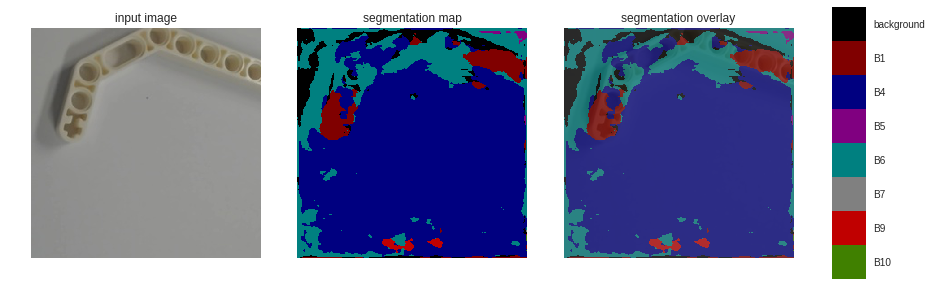

In [10]:
#@title Run on sample images {display-mode: "form"}

#Original at https://github.com/tensorflow/models/tree/master/research/deeplab

SAMPLE_IMAGE = "00000720" #@param {type:"string"}
IMAGE_URL = ''

_SAMPLE_URL = ('https://github.com/TadejSkapin/Inference/blob/master/Images/%s.jpg?raw=true')


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

In [14]:
#@title Evaluate performance { display-mode: "code" }

SAMPLE_IMAGE = "00000008" #@param {type:"string"}
IMAGE_URL = ''

_SAMPLE_URL = ('https://github.com/TadejSkapin/Inference/blob/master/Images/%s.jpg?raw=true')

def getClass(num):
    if num < 80:
        return 1
    elif num < 224:
        return 2
    elif num < 296:
        return 3
    elif num < 368:
        return 4
    elif num < 384:
        return 5
    elif num < 400:
        return 6
    elif num < 440:
        return 7
    elif num < 456:
        return 8
    elif num < 488:
        return 9
    elif num < 568:
        return 10
    elif num < 736:
        return 11
    elif num < 880:
        return 12

def evaluate_performance(label, actual_class):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')
    
  bins = np.bincount(label.flatten('C'))
  bins[0] = 0
  prediction = np.argmax(bins)
  #print('Most frequent pixel value: %d' % prediction)
  
  if prediction == actual_class:
    return 1
  else:
    return 0

def run_visualization(url, image_num):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  #print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)
  
  return evaluate_performance(seg_map, getClass(image_num))

num_correct_predictions = 0
num_images = 872
for i in range(0, num_images):
  image_url = IMAGE_URL or _SAMPLE_URL % '{num:08d}'.format(num = i)
  num_correct_predictions += run_visualization(image_url, i)
  
print('Correctly predicted %s out of %s images' % (num_correct_predictions, num_images))

Correctly predicted 30 out of 872 images
